## Penguin Classification

In [51]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer

In [52]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'taxis',
 'tips',
 'titanic']

In [53]:
df = sns.load_dataset('penguins')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [55]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [56]:
df = df.dropna()


In [57]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [58]:
encoder = LabelEncoder()
df["species"] = encoder.fit_transform(df["species"])
df["island"] = encoder.fit_transform(df["island"])
df["sex"] = encoder.fit_transform(df["sex"])

In [59]:
X = df.drop("species", axis=1)
y = pd.DataFrame(df["species"]).copy()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [61]:
scaler = StandardScaler()

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [63]:
clf = lgb.LGBMClassifier()

pipe = Pipeline([
    ("scaler", scaler),
    ("method", clf)
])

In [64]:
clf.fit(X_train, y_train.values.ravel())

LGBMClassifier()

In [65]:
y_train_pred = clf.predict(X_train)
print(f"Model accuracy on the training set : {accuracy_score(y_train, y_train_pred):.3f}")

Model accuracy on the training set : 1.000


In [66]:
y_test_pred = clf.predict(X_test)
print(f"Model accuracy on the training set : {accuracy_score(y_test, y_test_pred):.3f}")

Model accuracy on the training set : 1.000


In [67]:
haha = pipe.named_steps["method"]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

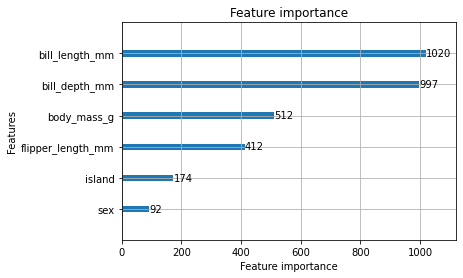

In [68]:
lgb.plot_importance(haha)